# <center> Отчет о выполненном проекте

### <center> Идентификация интернет-пользователей

### Выполнил: Кокоть Максим Игоревич

Среди соревнований и заданий, рассматриваемых в данном курсе и связанных с идентификацией интернет пользователей, для отчета было выбрано [соревнование](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle по идентификации взломщика по его поведению в сети Интернет. 

**Цель проекта:** применение полученных в ходе прохождениния специализаций знаний и навыков по машинному обучению и анализу данных.

**Задача проекта:** создать алгоритм, который будет анализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, и определять, Элис это или взломщик (кто-то другой).

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import learning_curve

**Считаем данные [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) в DataFrame train_df и test_df (обучающая и тестовая выборки).**

In [2]:
PATH_TO_DATA = 'capstone_user_identification'

In [3]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [5]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


Объекты в датафрейме представляют собой сессии в сети интернет. В каждой сессии максимум 10 сайтов, для каждого сайта в сессиях известно время его посещения. Каждая сессия длится максимум полчаса. Признаки site1 - site10 содержат id сайтов в словаре site_dic.pkl. Признаки time1 - time10 - время посещения сайтов. target - целевой признак, принимающий значение 1, если сессия принадлежит Alice, 0 - в противном случае.

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
site1     253561 non-null int64
time1     253561 non-null object
site2     250098 non-null float64
time2     250098 non-null object
site3     246919 non-null float64
time3     246919 non-null object
site4     244321 non-null float64
time4     244321 non-null object
site5     241829 non-null float64
time5     241829 non-null object
site6     239495 non-null float64
time6     239495 non-null object
site7     237297 non-null float64
time7     237297 non-null object
site8     235224 non-null float64
time8     235224 non-null object
site9     233084 non-null float64
time9     233084 non-null object
site10    231052 non-null float64
time10    231052 non-null object
target    253561 non-null int64
dtypes: float64(9), int64(2), object(10)
memory usage: 42.6+ MB


In [16]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 65540 to 60141
Data columns (total 20 columns):
site1     82797 non-null int64
time1     82797 non-null object
site2     81308 non-null float64
time2     81308 non-null object
site3     80075 non-null float64
time3     80075 non-null object
site4     79182 non-null float64
time4     79182 non-null object
site5     78341 non-null float64
time5     78341 non-null object
site6     77566 non-null float64
time6     77566 non-null object
site7     76840 non-null float64
time7     76840 non-null object
site8     76151 non-null float64
time8     76151 non-null object
site9     75484 non-null float64
time9     75484 non-null object
site10    74806 non-null float64
time10    74806 non-null object
dtypes: float64(9), int64(1), object(10)
memory usage: 13.3+ MB


Посмотрим на распределение целевого признака в обучающей выборке.

In [25]:
train_df.target.value_counts()

0    251264
1      2297
Name: target, dtype: int64

Наблюдаем дисбаланс классов. Неудивительно, что при оценке предсказаний на kaggle используется метрика ROC AUC.

Отсортируем сессии в обучающей выборке в хронологическом порядке.

In [4]:
train_df = train_df.sort_values('time1', axis=0)

Объединим обучающую и тестовую выборку для последующего извлечения признаков. 

In [5]:
sites = ['site%d' % i for i in range(1, 11)]
times = ['time%d' % i for i in range(1, 11)]

In [6]:
train_test_df = pd.concat([train_df, test_df])

Переведем значения признаков time1 - time10 в формат datetime64[ns] для удобного извлечения новых признаков из данных. Заменим пропуски в сайтах на нули (значение ранее не использовалось).

In [7]:
train_test_df[times] = train_test_df[times].astype('datetime64[ns]')
train_test_df[sites] = train_test_df[sites].fillna(0).astype('int')
train_df[sites].iloc[:train_df.shape[0], :].to_csv('train.txt', sep=' ', index=None, header=None)
test_df[sites].iloc[train_df.shape[0]:, :].to_csv('test.txt', sep=' ', index=None, header=None)

Данные в представленном виде недоступны для анализа. Необходимы предобработка и построение новых признаков.

### Создание разреженных матриц для сайтов

Прежде всего, создадим разреженные матрицы для сайтов.

In [8]:
train_test_sparse = csr_matrix((np.ones(train_test_df[sites].values.size), train_test_df[sites].values.ravel(), 
                                [10*i for i in range(train_test_df[sites].shape[0]+1)]), dtype=int)[:,1:]
X_train_sparse = train_test_sparse[:train_df.shape[0], :]
X_test_sparse = train_test_sparse[train_df.shape[0]:, :]
y = train_df['target']

### Выделение новых признаков из исходных

Из имеющихся данных выделим следующие признаки, доступные для интерпретации:
    
    - session_timespan - длительность сессии;
    - istop10 - вхождение хотя бы одного сайта в сессии в топ-10; 
    - issinglesite - вхождение хотя бы одного сайта-одиночки (с частотой 1 в словаре сайтов) в сессии; 
    - starthour - час суток начала сессии (утро, день вечер, ночь);
    - dayofweek - день недели;
    - unique_sites - число уникальных сайтов в сессии.

Создадим признак session_timespan - длительность сессии. Посмотрим на его распределение.

In [9]:
train_test_df['min'] = train_test_df[times].min(axis=1)
train_test_df['max'] = train_test_df[times].max(axis=1)
train_test_df['session_timespan'] = ((train_test_df['max'] - train_test_df['min']) / np.timedelta64(1, 's'))

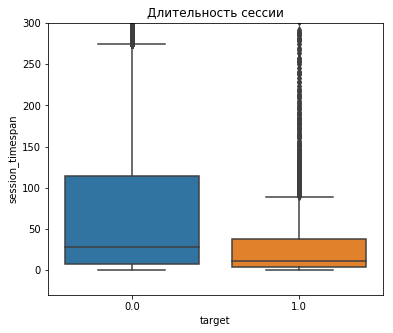

In [16]:
plt.figure(figsize=(6, 5))
sns.boxplot(x='target', y='session_timespan', data=(train_test_df.iloc[:train_df.shape[0], :]))
plt.title('Длительность сессии')
plt.ylim(-30,300);

Видим, что Элис проводит время в сети меньше, чем другие пользователи.

In [113]:
train_test_df.iloc[:train_df.shape[0], :][
    train_test_df.iloc[:train_df.shape[0], :]['target'] == 1]['session_timespan'].describe()

count    2297.000000
mean       52.296474
std       153.309014
min         0.000000
25%         4.000000
50%        11.000000
75%        38.000000
max      1763.000000
Name: session_timespan, dtype: float64

Создадим признаки-индикаторы длинных и коротких сессий short и long. В качестве порога разбиения выберем 0,75-квантиль распределения длительности сессии у Элис, равный 38 секундам.

In [17]:
train_test_df['short'] = (train_test_df['session_timespan'] >= 38).astype('int')
train_test_df['long'] = (train_test_df['session_timespan'] < 38).astype('int')

Создадим признак 'starthour' - час начала сессии. Посмотрим на его распределение.

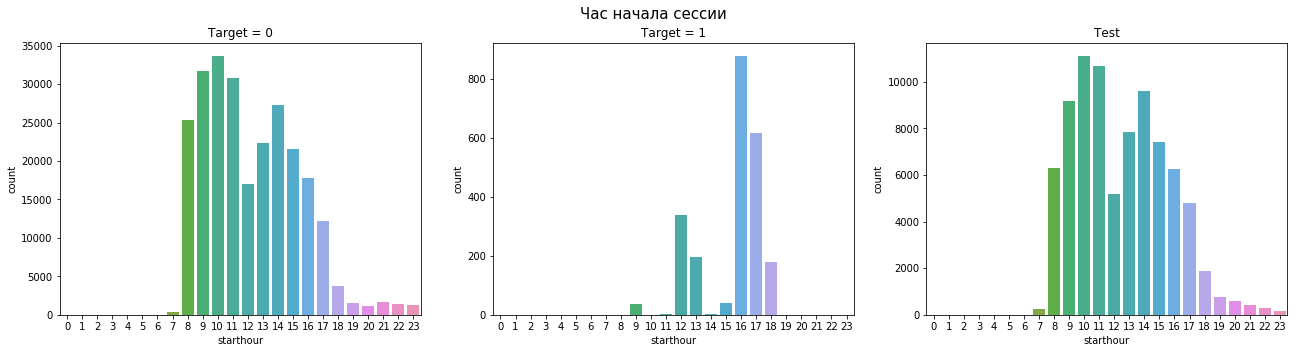

In [28]:
train_test_df['starthour'] = train_test_df['time1'].apply(lambda ts: ts.hour)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,5))
plt.suptitle('Час начала сессии', size=15)
sns.countplot(train_test_df.iloc[:train_df.shape[0], :][
    train_test_df.iloc[:train_df.shape[0], :]['target'] == 0]['starthour'], order = np.arange(24), ax = axes[0])
sns.countplot(train_test_df.iloc[:train_df.shape[0], :][
    train_test_df.iloc[:train_df.shape[0], :]['target'] == 1]['starthour'], order = np.arange(24), ax = axes[1]) 
sns.countplot(train_test_df.iloc[train_df.shape[0]:, :]['starthour'], order = np.arange(24), ax = axes[2])
axes[0].set_title("Target = 0")
axes[1].set_title("Target = 1")
axes[2].set_title("Test"); 

Видим, что распределения мультимодальные. Элис начинает сессию в определенные времена суток. На основании этого можно выделить признаки-индикаторы времени суток начала сессии. Выделим следующие периоды:

   - 7-11 - утро;
   - 12-18 - день;
   - 19-23 - вечер;
   - 0-6 - ночь.

In [29]:
train_test_df['morning'] = ((train_test_df['starthour'] >= 7) & (train_test_df['starthour'] <= 11)).astype('int')
train_test_df['day'] = ((train_test_df['starthour'] >= 12) & (train_test_df['starthour'] <= 18)).astype('int')
train_test_df['evening'] = ((train_test_df['starthour'] >= 19) & (train_test_df['starthour'] <= 23)).astype('int')
train_test_df['night'] = ((train_test_df['starthour'] >= 0) & (train_test_df['starthour'] <= 6)).astype('int')

Создадим признак 'dayofweek' - дни недели. Посмотрим на его распределение.

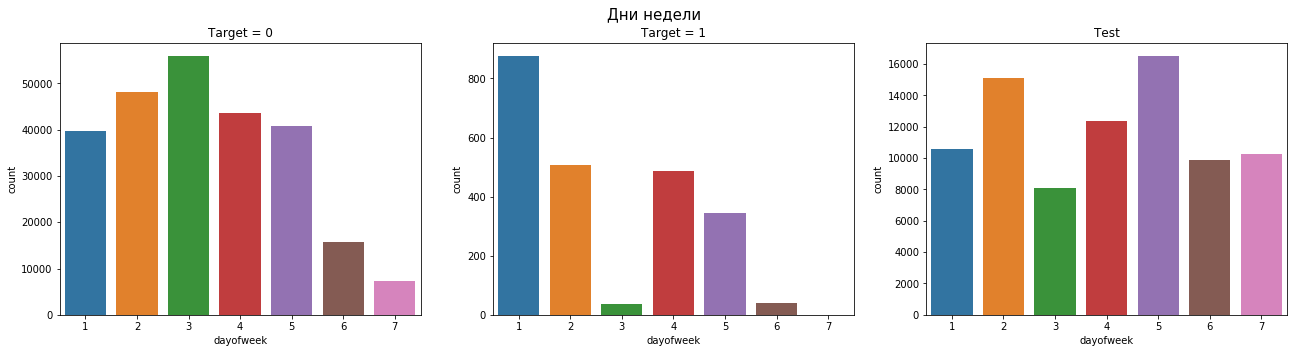

In [30]:
train_test_df['dayofweek'] = train_test_df['time1'].apply(lambda ts: ts.isoweekday())
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,5))
plt.suptitle('Дни недели', size=15)
sns.countplot(train_test_df.iloc[:train_df.shape[0], :][
    train_test_df.iloc[:train_df.shape[0], :]['target'] == 0]['dayofweek'], order = np.arange(1,8), ax=axes[0])
sns.countplot(train_test_df.iloc[:train_df.shape[0], :][
    train_test_df.iloc[:train_df.shape[0], :]['target'] == 1]['dayofweek'], order = np.arange(1,8), ax=axes[1])
sns.countplot(train_test_df.iloc[train_df.shape[0]:, :]['dayofweek'], order = np.arange(1,8), ax=axes[2])
axes[0].set_title("Target = 0")
axes[1].set_title("Target = 1")
axes[2].set_title("Test"); 

Видим, что Элис отличает от других пользователей частый вход в сеть по понедельникам и довольно редкие посещения по средам, субботам и воскресеньям. На основании этого добавим признаки-индикаторы понедельника, среды, субботы и воскресенья.

In [31]:
train_test_df['mon'] = (train_test_df['dayofweek'] == 1).astype('int')
train_test_df['wen'] = (train_test_df['dayofweek'] == 3).astype('int')
train_test_df['sat'] = (train_test_df['dayofweek'] == 6).astype('int')
train_test_df['sun'] = (train_test_df['dayofweek'] == 7).astype('int')

Создадим списки топ-10 популярных сайтов и сайтов, встречающихся лишь один раз в обучающей выборке.

In [32]:
freq = np.unique(train_test_df.loc[:train_df.shape[0], :][sites].values.flatten(), return_counts = True)
freq = pd.Series(freq[1], index=freq[0]).sort_values(ascending=False)
top10 = freq.index[freq.index != 0][0:10]
singlesites = pd.Series(train_df[sites].values.flatten()
                     ).value_counts().sort_values(ascending=False)[pd.Series(train_df[sites].values.flatten()
                     ).value_counts().sort_values(ascending=False) == 1].index

Создадим признак istop10 - вхождение хотя бы одного сайта в сессии в топ-10. Посмотрим на его распределение.

In [33]:
train_test_df['istop10'] = train_test_df[sites].apply(lambda s: int(np.intersect1d(s, top10).size >= 1), axis=1)

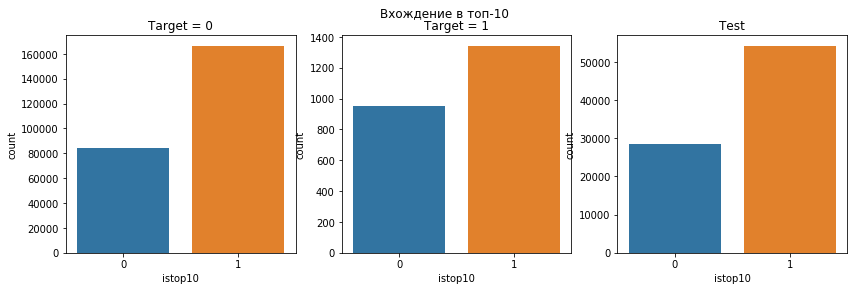

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
plt.suptitle('Вхождение в топ-10', size=12)
sns.countplot(train_test_df.iloc[:train_df.shape[0], :][
    train_test_df.iloc[:train_df.shape[0], :]['target'] == 0]['istop10'], ax = axes[0])
sns.countplot(train_test_df.iloc[:train_df.shape[0], :][
    train_test_df.iloc[:train_df.shape[0], :]['target'] == 1]['istop10'], ax = axes[1])
sns.countplot(train_test_df.iloc[train_df.shape[0]:, :]['istop10'], ax = axes[2])
axes[0].set_title("Target = 0")
axes[1].set_title("Target = 1")
axes[2].set_title("Test"); 

Посмотрим на доли целевого класса при разных значениях признака 'istop10' в обучающей выборке.

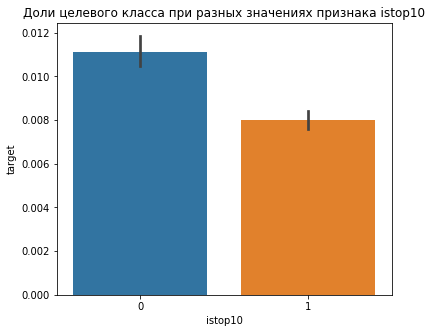

In [38]:
plt.figure(figsize=(6, 5))
sns.barplot(x='istop10', y="target", data=train_test_df.iloc[:train_df.shape[0], :]) 
plt.title('Доли целевого класса при разных значениях признака istop10');

Видим, что отличия между распределеними не такие уж значительные. Скорее всего, использования данного признако не повлияет в лучшую сторону на качество прогноза.

Создадим признак issinglesite - вхождение хотя бы одного сайта-одиночки (с частотой 1 в словаре сайтов) в сессии. Посмотрим на его распределение.

In [39]:
train_test_df['issinglesite'] = train_test_df[sites].apply(lambda s: np.intersect1d(
    s, singlesites).size >= 1, axis=1).astype('int')

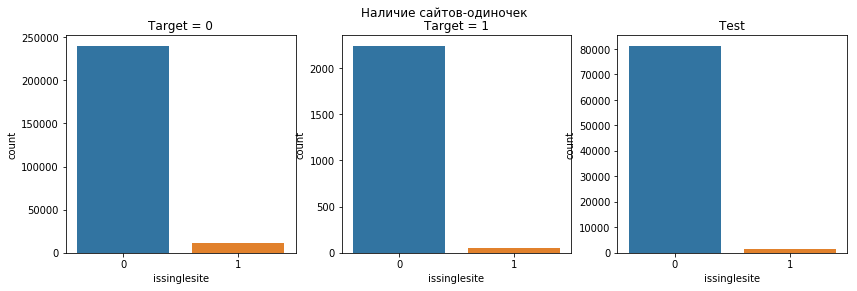

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
plt.suptitle('Наличие сайтов-одиночек', size=12)
sns.countplot(train_test_df.iloc[:train_df.shape[0], :][
    train_test_df.iloc[:train_df.shape[0], :]['target'] == 0]['issinglesite'], ax = axes[0])
sns.countplot(train_test_df.iloc[:train_df.shape[0], :][
    train_test_df.iloc[:train_df.shape[0], :]['target'] == 1]['issinglesite'], ax = axes[1])
sns.countplot(train_test_df.iloc[train_df.shape[0]:, :]['issinglesite'], ax = axes[2])
axes[0].set_title("Target = 0")
axes[1].set_title("Target = 1")
axes[2].set_title("Test");

Посмотрим на доли целевого класса при разных значениях признака 'issinglesite' в обучающей выборке.

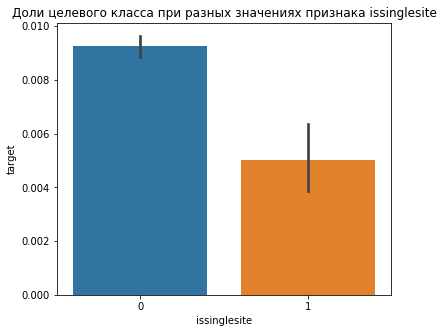

In [42]:
plt.figure(figsize=(6, 5))
sns.barplot(x='issinglesite', y="target", data=train_test_df.iloc[:train_df.shape[0], :]) 
plt.title('Доли целевого класса при разных значениях признака issinglesite');

Видим, что доли отличаются. В сессиях Элис немного сайтов-одиночек.

Создадим признак unique_sites - число уникальных сайтов в сессии. Посмотрим на его распределение.

In [43]:
train_test_df['unique_sites'] = train_test_df[sites].apply(lambda s: np.unique(s[s != 0]).size, axis=1)

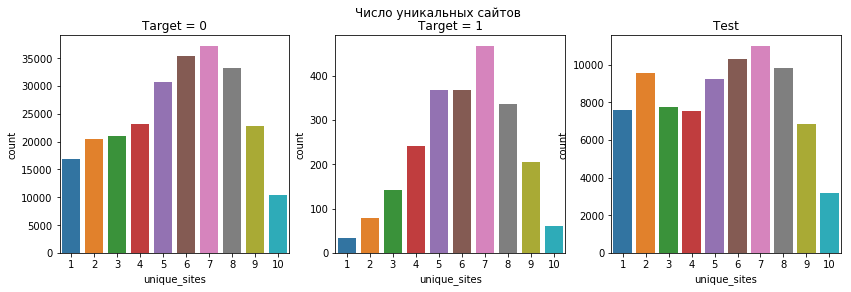

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
plt.suptitle('Число уникальных сайтов', size=12)
sns.countplot(train_test_df.iloc[:train_df.shape[0], :][
    train_test_df.iloc[:train_df.shape[0], :]['target'] == 0]['unique_sites'], ax = axes[0], order = np.arange(1,11))
sns.countplot(train_test_df.iloc[:train_df.shape[0], :][
    train_test_df.iloc[:train_df.shape[0], :]['target'] == 1]['unique_sites'], ax = axes[1], order = np.arange(1,11))
sns.countplot(train_test_df.iloc[train_df.shape[0]:, :]['unique_sites'], ax = axes[2], order = np.arange(1,11))
axes[0].set_title("Target = 0")
axes[1].set_title("Target = 1")
axes[2].set_title("Test");

Видим, что число распределения отличаются хвостами, мода у них одна и та же.

### Подготовка данных для обучения

Посмотрим на датасет train_test_df. Сейчас он содержит 39 признаков, включая целевой.

In [46]:
train_test_df.head()

,site1,site10,site2,site3,site4,site5,site6,site7,site8,site9,...,evening,night,dayofweek,mon,wen,sat,sun,istop10,issinglesite,unique_sites
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,0,55,0,0,0,0,0,0,0,...,0,0,6,0,0,1,0,0,0,2
54843,56,0,55,56,55,0,0,0,0,0,...,0,0,6,0,0,1,0,0,0,2
77292,946,946,946,951,946,946,945,948,784,949,...,0,0,6,0,0,1,0,0,0,6
114021,945,946,948,949,948,945,946,947,945,946,...,0,0,6,0,0,1,0,0,0,5
146670,947,947,950,948,947,950,952,946,951,946,...,0,0,6,0,0,1,0,0,0,6


In [47]:
train_test_df.columns

Index(['site1', 'site10', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7',
       'site8', 'site9', 'target', 'time1', 'time10', 'time2', 'time3',
       'time4', 'time5', 'time6', 'time7', 'time8', 'time9', 'min', 'max',
       'session_timespan', 'short', 'long', 'starthour', 'morning', 'day',
       'evening', 'night', 'dayofweek', 'mon', 'wen', 'sat', 'sun', 'istop10',
       'issinglesite', 'unique_sites'],
      dtype='object')

После проделанного ранее анализа новых признаков, в обучение включим следующие признаки:

   - morning - индикатор утра;
   - day - индикатор дня;
   - evening - индикатор вечера;
   - night - индикатор ночи;
   - mon - индикатор понедельника;
   - wen - индикатор среды;
   - sat - индикатор субботы;
   - sun - индикатор воскресенья;
   - issinglesite - вхождение хотя бы одного сайта-одиночки (с частотой 1 в словаре сайтов) в сессии;
   - short - индикатор короткой сессии;
   - long - индикатор длинной сессии.

In [48]:
feat = train_test_df[['morning', 'day', 'evening', 'night', 'mon', 'wen',
       'sat', 'sun', 'issinglesite', 'short', 'long']]

Обратно разобьем датасет на обучение и тест.

In [49]:
feat_train = feat.iloc[:train_df.shape[0], :]
feat_test = feat.iloc[train_df.shape[0]:, :]

Объединим отобранные признаки с созданными ранее разреженными матрицами.

In [153]:
myXtrain = csr_matrix(hstack((X_train_sparse, feat_train.values)))
myXtest = csr_matrix(hstack((X_test_sparse, feat_test.values)))

### Создание и обучение модели

Для решения задачи бинарной классификации будем использовать логистистическую регрессию. Так как объекты в датасете (сессии) имеют привязку ко времени, то в качестве стратегии кросс-валидации выберем TimeSeriesSplit. Ее описание можно найти [здесь](https://habr.com/ru/company/ods/blog/327242/).

Цитата из статьи:
"Суть достаточно проста — начинаем обучать модель на небольшом отрезке временного ряда, от начала до некоторого t, делаем прогноз на t + n шагов вперед и считаем ошибку. Далее расширяем обучающую выборку до t + n значения и прогнозируем с t + n до t + 2n, так продолжаем двигать тестовый отрезок ряда до тех пор, пока не упрёмся в последнее доступное наблюдение. В итоге получим столько фолдов, сколько n уместится в промежуток между изначальным обучающим отрезком и всей длиной ряда."

Мы будем использовать 10 фолдов.

In [52]:
time_split = TimeSeriesSplit(n_splits=10)

Как было сказано в начале курса, линейные модели не стоит недооценивать: они быстрые, могут работать на очень больших выборках. Поэтому мы будем использовать логистическую регрессию.

In [53]:
logit = LogisticRegression(C=1, random_state=17, solver='liblinear')

Воспользуемся поиском по сетке. Создадим объект GridSearchCV. Будем подбирать значение параметра регуляризации С.

In [54]:
c_values = np.logspace(-2, .5, 10)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=1, cv=time_split, verbose=1)

Обучим модель.

In [154]:
%%time
logit_grid_searcher.fit(myXtrain, y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  7.4min finished


Wall time: 7min 38s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=17, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'C': array([0.01   , 0.01896, 0.03594, 0.06813, 0.12915, 0.24484, 0.46416,
       0.87992, 1.6681 , 3.16228])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [155]:
print ('ROC-AUC', logit_grid_searcher.best_score_)

ROC-AUC 0.9219888026354025


### Использование n-грамм сайтов 

Видим, что результат вполне неплох. Однако его можно улучшить, воспользовавшись модулем CountVectorizer в sklearn. Данный модуль позволяет построить n-граммы сайтов. Воспользуемся им для замены созданных ранее разреженных матриц.

In [50]:
CountVec = CountVectorizer(ngram_range=(1, 3), max_features=65000)
with open('train.txt') as file:
    X_train_count_vec = CountVec.fit_transform(file)
with open('test_sessions_text.txt') as file:
    X_test_count_vec = CountVec.transform(file)

In [51]:
myXtrain = hstack((X_train_count_vec, feat_train.values))
myXtest = hstack((X_test_count_vec, feat_test.values))

In [55]:
%%time
logit_grid_searcher.fit(myXtrain, y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 15.5min finished


Wall time: 15min 49s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=17, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'C': array([0.01   , 0.01896, 0.03594, 0.06813, 0.12915, 0.24484, 0.46416,
       0.87992, 1.6681 , 3.16228])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [56]:
print ('ROC-AUC', logit_grid_searcher.best_score_)

ROC-AUC 0.9246736487989293


Видим, что результат несколько лучше.

### Оценка качества модели

Построим кривые валидации.

In [57]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    plt.figure(figsize=(8, 5))
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='valid', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.xlabel('C')
    plt.ylabel('ROC-AUC')
    plt.title('Кривые валидации')
    plt.legend()

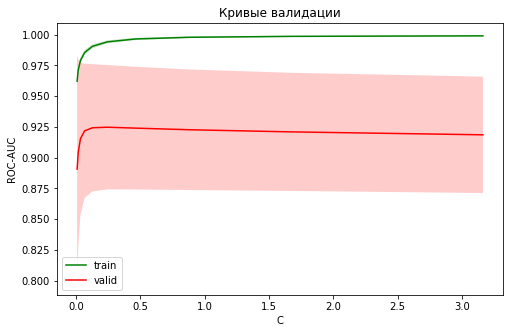

In [58]:
plot_validation_curves(c_values, logit_grid_searcher.cv_results_)

Две кривые располагаются недалеко друг от друга, значения ROC-AUC на тесте относительно высокие. Это значит, что переобучения удалось избежать. 

Построим кривую обучения.

In [59]:
def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    plt.figure(figsize=(12, 5))
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.title('Кривые обучения')
    plt.legend(loc='lower right');

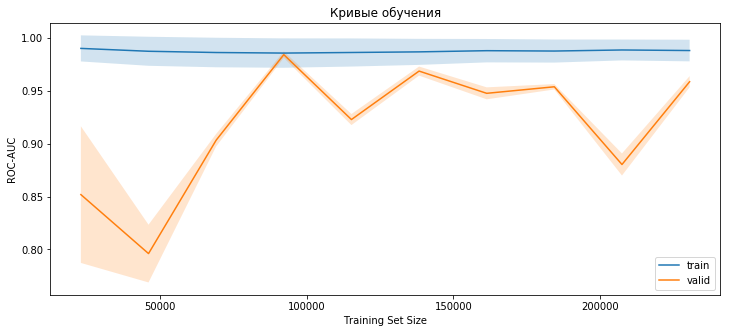

In [60]:
splitstest = ['split{}_test_score'.format(x) for x in range(10)]
splitstrain = ['split{}_train_score'.format(x) for x in range(10)]
restest = np.array([logit_grid_searcher.cv_results_[x] for x in splitstest]) 
restrain = np.array([logit_grid_searcher.cv_results_[x] for x in splitstrain])
train_sizes = [el[0].shape[0] for el in time_split.split(myXtrain)]
plot_learning_curve(restrain, restest, train_sizes=train_sizes, 
                        xlabel='Training Set Size', ylabel='ROC-AUC')

Несмотря на провал в предпоследнем разбиении, кривые обучения более-менее сошлись, и метрика ROC-AUC на валидационных подвыборках имеет тенденцию возрастать с ростом обучающей подвыборки. Возможно, добавление новых данных помогло бы улучшить качество модели.

### Загрузка прогноза на Kaggle

Сделаем предсказания для тестовой выборки.

In [114]:
pred = logit_grid_searcher.best_estimator_.predict_proba(myXtest)[:, 1]

Запишем прогноз в файл и загрузим на Kaggle.

In [115]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [116]:
write_to_submission_file(pred, out_file='finpred')

В итоге получаем результат ROC-AUC = 0.94735 в публичной части лидерборда (имя команды: [YDF & MIPT] Кокоть Максим Игоревич). Довольно неплохой результат.

### Выводы по проделанному проекту

Данный проект позволил проявить собственные навыки в предобработке данных, EDA, создании новых признаков, выборе стратегии кросс-валидации и оптимальных параметров модели. Полученная модель имеет практическую значимость: с помощью нее можно идентифицировать взломщика почтового ящика по его поведению в сети. Таким образом, данная модель позволяет поддерживать безопасность аккаунтов пользователей какого-либо сервиса.

У модели довольно хорошие показатели на обучении и неплохой результат в публичной части рейтинга на Kaggle. В ходе выполнения задания было принято решение об улучшении модели с помощью использования n-грамм, и результат не заставил себя ждать. В качестве возможного улучшения модели в дальнейшем можно попробовать извлечь больше признаков (например, домены верхнего уровня сайтов) и/или применить другие классификаторы.

# <center> Спасибо за внимание! :)